<a href="https://colab.research.google.com/github/FRJackson/hw/blob/main/Problem3_Autodiff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GR5242 HW04 Problem 3: Automatic Differentiation**

**Instructions**: This problem is an individual assignment -- you are to complete this problem on your own, without conferring with your classmates.  You should submit a completed and published notebook to Gradescope; no other files will be accepted.

## Description:

This homework adds more detail to the autodiff lecture in class. There are six questions in total, which include coding and written questions. You should only modify the code and text within \### YOUR CODE HERE ### and/or \### YOUR ANSWER HERE ###.


In [ ]:
!pip install micrograd
!pip install graphviz

In [ ]:
import micrograd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from micrograd.engine import Value
from graphviz import Digraph

## Differentiation

**Different ways of differentiation:** In this problem we consider a particular function (which we call it an `op` in the code block, short for operation) $f:\mathbb{R} \to \mathbb{R}: x \mapsto 4x(1-x)$ and it's compositions with itself. Let us define,
$$ g_n: \underbrace{f \circ \dots \circ f}_{n \text{ times}}: x \mapsto f^{(n)}(x) $$
where $f^{(n)}(x) = f(f^{(n-1)}(x))$ is the $n$ times composited function $f$ with itself. The goal of this problem is to explore various ways of differentiation, i.e. $\frac{d}{dx}g_{n}(x)$ which are listed below:
- Numerical differentiation
- Manual differentiation
- Autodiff in forward or reverse mode

In [ ]:
def op(input):
  return 4 * input * ( 1 - input )

def operation(input, n = 1):
  temp = input
  for i in range(n):
    temp = op(temp) # apply this operation n times
  return temp

## Numerical Differentiation

Based on the definition of derivative at a particular point $x_0$,

$$ \frac{d}{dx}g_n(x_0) = \lim_{h \to 0} \frac{g_n(x_0+h) - g_n(x_0)}{h} =: \lim_{h \to 0} D_h g_n(x_0) $$

The formula above suggests a simple way of **approximating** the derivative by taking $D_{h}g_n(x_0)$ for a particular choice of $h$ as your approximate derivative. This is also known as the [finite difference](https://en.wikipedia.org/wiki/Numerical_differentiation) method. Note that this approach only requires evaluation of your function around the point you are trying to take the derivative at so it's computationally efficient but the caveat is that choosing a proper $h$ to obtain good enough approximations is generally hard (specially when the function is multivariate). However, in our case we have some structure over the function we are trying to take derivative of.

**Question 1:** Use a finite difference with tolerance 1e-12 to approximate the derivative of $g_3(x)$ at $x=1$:

In [ ]:
tol = 1e-12
### YOUR CODE HERE ###
# --- Q1: numerical derivative of g3 at x=1 with finite difference tolerance 1e-12 ---

def finite_diff_forward(func, x0, tol=1e-12, h0=1e-4, max_iter=60):
    """Forward finite difference with adaptive step size to meet a tolerance."""
    h = h0
    # 初始一次近似
    prev = (func(x0 + h) - func(x0)) / h
    for _ in range(max_iter):
        h *= 0.5                      # 将步长减半，减小截断误差
        cur = (func(x0 + h) - func(x0)) / h
        # 收敛判据：两次近似之差足够小（相对+绝对容差）
        if abs(cur - prev) <= tol * (1.0 + abs(cur)):
            return cur, h
        prev = cur
    return prev, h                    # 若到上限仍未满足容差，就返回当前最好值

# 定义 g3(x) = f∘f∘f(x)，这里复用你上面给的 operation(input, n)
def g3(x):
    return operation(x, n=3)

# 计算在 x=1 处的数值导数
deriv_g3_at_1, used_h = finite_diff_forward(g3, x0=1.0, tol=tol)

print("Approx d/dx g3(x) at x=1 =", deriv_g3_at_1)
print("Final step size h used   =", used_h)


Approx d/dx g3(x) at x=1 = -64.08691406253136
Final step size h used   = 2.3283064365386964e-14


The approximation will be bad at certain points $x$, and becomes less stable as $n$ becomes larger for a fixed $h$ (or as the dimensionality of the function grows).  

## Calculus and manual differentiation

Notice that $f$ is a polynomial and that composition of polynomials yields also a polynomial. Therefore, $g_n$ is a polynomial with degree $2^n$ (try to argue this for yourself using induction); we can compute the derivative using  calculus.

Recall our function:
$$ g_n​(x)=f(g_{n−1}​(x))$$

where $f(x)=4x(1−x)$.

It is not difficult to (manually) derive a closed form expression for $g_n$ using the recursive formula
$$ g_n(x) = 4 g_{n-1}(x) (1-g_{n-1}(x)), \quad g_{1}(x) = 4x(1-x).$$  



**Question 2:** Manually compute the exact derivative $g_3'(x)$ at $x=1$. Show all steps (i.e. compute $g_1'(x)$, $g_1(x)$, $g_2'(x)$, $g_2(x)$, etc.)

\### YOUR ANSWER HERE \###

In Question 2, we manually computed the derivative $g_3'​(1)$ by recursively applying the chain rule. This process, where we compute the value and its derivative at the same time in a forward pass, is called forward-mode automatic differentiation.

$$(g_1, g_1') → (g_2, g_2') →⋯→(g_n, g_n')$$

Now, let's program this logic.

**Question 3:** Modify the functions `op` and `operation` with their counterparts `op_with_grad` and `operation_with_grad` using the logic explained above to compute the derivative of $g_n$. Check your function by evaluating it at $x=1$.

In [ ]:
### Your Code Here ###
def op_with_grad(input, grad):
    # 计算 y = f(input) = 4*input*(1 - input)，并把梯度在正向模式下推进
    y = 4 * input * (1 - input)          # y = f(v)
    fprime = 4 - 8 * input               # f'(v) = 4 - 8v
    g = fprime * grad                    # dy/dx = f'(v) * dv/dx
    return y, g                          # 返回 (数值, 对x的导数)

def operation_with_grad(input, n=1):
    # 将 f 复合 n 次，并正向传播梯度：从 (x, 1) 开始，迭代调用 op_with_grad
    val = input                          # 当前复合后的函数值 v
    grad = 1.0                           # dv/dx，初始对 x 的导数为 1
    for _ in range(n):                   # 执行 n 次复合
        val, grad = op_with_grad(val, grad)
    return val, grad                     # 返回 g_n(x) 与 g_n'(x)

# 例：在 x=1 处检查 n=3
v13, d13 = operation_with_grad(1.0, n=3)
print("g3(1) =", v13, "  g3'(1) =", d13)


g3(1) = 0.0   g3'(1) = -64.0


Fortunately, `torch` can do last part for us! As was discussed in class, `torch` interprets our code and builds up a computation graph using operations that knows their gradients already and complements each operation with their backward gradient; in order to compute the gradient it follows the following backwards path

$$ \left(g_n, \frac{\partial}{\partial g_n}g_n \right) \to \left(g_{n-1}, \frac{\partial}{\partial g_{n-1}}g_{n}\right) \to \left(g_1, \frac{\partial}{\partial g_1}g_n\right) \to \left(g_0, \frac{\partial}{\partial g_0}g_n\right) $$

where $g_0(x) = x$ is the identity function. For the purposes of this assignment, we'll be using `micrograd` as our autodiff engine.

**Question 4:** Use `micrograd` to calculate the derivative of g_n(x) with respect to x

In [ ]:
def micro_op(input):
  # f(x) = 4x(1-x)
  return 4 * input * (1 - input)

def micro_operation(input, n = 1):
  temp = input
  for i in range(n):
    temp = micro_op(temp) # apply this operation n times
  return temp

In [ ]:
# Input variable x
x = Value(1.0)

### YOUR CODE HERE ###
# Step 1: Apply the micro_operation (with n=3)
g = micro_operation(x, n=3)

# Step 2: Compute gradients by backpropagation
g.backward()

# Step 3: The gradient is stored in x.grad
df_dx = x.grad

print(f"The final value is: {g.data}")
print(f"The derivative (gradient) is: {df_dx}")


The final value is: 0.0
The derivative (gradient) is: -64.0


In [ ]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


In [ ]:
# Make sure 'g' is the final output Value from your answer to Q7
dot = draw_dot(g)
dot.render('g3_computation_graph', format='png')

'g3_computation_graph.png'

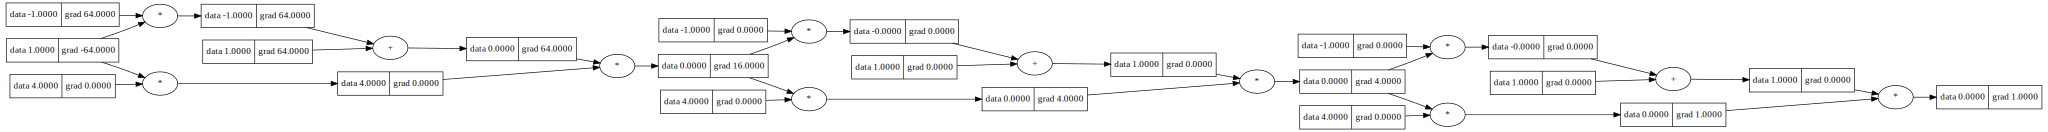

In [ ]:
dot

**Question 5:** Look at the node for our input $x$ (it will be on the very left). Verify that its grad attribute matches the answer you got. How does this visualization relate to the $g_n(x)=f(g_{n-1}(x))$ structure we've been studying?

\### YOUR ANSWER HERE \###

:



## Implementing a new operation



So far, micrograd has known how to handle operations like + and *. But what if we want to use a function it doesn't know about, like an activation function? We'll have to specify how to compute the backward pass for that new operation.

The `Value` object's `_backward` attribute is a function that micrograd calls to propagate the gradient. It's our job to define that function.

**Question 6:** Implement the `my_relu(x)` function that operates on a micrograd Value object.

Recall the ReLU function:
$$\text{ReLU}(x) = \begin{cases} x & \text{if } x > 0 \\ 0 & \text{if } x \le 0 \end{cases}$$

And its derivative:
$$\frac{d}{dx}\text{ReLU}(x) = \begin{cases} 1 & \text{if } x > 0 \\ 0 & \text{if } x \le 0 \end{cases}$$

In [ ]:
from micrograd.engine import Value

def my_relu(x_val: Value):
    # 1. Forward pass: compute the output value
    out_data = x_val.data if x_val.data > 0 else 0.0

    # 2. Create output Value, link it to its parent
    out = Value(out_data, _children=(x_val,), _op='ReLU')

    # 3. Define backward pass
    def _backward_fn():
        # 局部导数 dReLU/dx：仅当 x>0 时梯度为1，否则为0
        local_grad = 1.0 if x_val.data > 0 else 0.0
        # 将梯度传播回输入节点
        x_val.grad += local_grad * out.grad

    # 4. Attach backward function to output
    out._backward = _backward_fn

    return out


In [ ]:
# Test Case 1: Positive input
x1 = Value(3.0)
r1 = my_relu(x1)
r1.backward()

print(f"Test 1 (x=3.0):")
print(f"  Output value: {r1.data}")
print(f"  Gradient (dL/dx): {x1.grad}")

# Test Case 2: Negative input
x2 = Value(-2.0)
r2 = my_relu(x2)
r2.backward()

print(f"\nTest 2 (x=-2.0):")
print(f"  Output value: {r2.data}")
print(f"  Gradient (dL/dx): {x2.grad}")

Test 1 (x=3.0):
  Output value: 3.0
  Gradient (dL/dx): 1.0

Test 2 (x=-2.0):
  Output value: 0.0
  Gradient (dL/dx): 0.0
